1.Introduction


This report presents a media file processing application that allows users to convert video formats, change video resolutions, and extract audio from video files. The application is built using the ffmpeg library and is designed to be user-friendly with a command-line interface. Our project focuses on creating a robust video processing application using various software design patterns such as Singleton, Factory, Command, and Adapter patterns. The main objective is to provide an extensible and efficient solution for video processing tasks, including video conversion, resolution change, and audio extraction.

The libraries and environment required for the entire project are as follows:

In [ ]:
!pip install ffmpeg-python watchdog

import ffmpeg
import os
import logging
from abc import ABC, abstractmethod
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.4 MB/s eta 0:00:00


2.Requirements Analysis

Functional Requirements
Video Conversion: The application should convert videos from one format to another.
Resolution Change: The application should change the resolution of videos.
Audio Extraction: The application should extract audio from videos.
Watermark and Color Enhancement: The application should add watermarks and enhance colors in videos.
Third-Party Conversion Integration: The application should support third-party video conversion services.
Non-Functional Requirements
Performance: The application should process videos efficiently without significant delays.
Scalability: The design should allow easy integration of additional video processing features.
Usability: The application should provide a user-friendly interface for input and output operations.
Maintainability: The codebase should follow best practices to facilitate maintenance and future development.
User Requirements
Users should be able to select and specify input video files and desired output formats.
Users should receive notifications about the success or failure of processing tasks.
Users should have the ability to save processing logs.

3.System Design

Architecture Design
The system architecture employs several design patterns to achieve modularity and extensibility. Specifically, eight design patterns have been used:
Singleton Pattern: Manages a single instance of the FFmpeg utility.
Factory Pattern: Creates instances of different video processing tasks.
Command Pattern: Encapsulates processing requests as objects, allowing parameterization of clients with queues, requests, and operations.
Adapter Pattern: Integrates third-party video conversion services.
Decorator Pattern: Adds additional functionality such as watermarking and color enhancement to video processing.
Observer Pattern: Notifies users about the success or failure of processing tasks.
Strategy Pattern: Defines a family of algorithms, encapsulates each one, and makes them interchangeable. Used for saving logs in different formats.
Template Method Pattern: Defines the skeleton of an algorithm in the base class but allows subclasses to override specific steps of the algorithm without changing its structure.
Following is the UML class diagram covering the entire code:
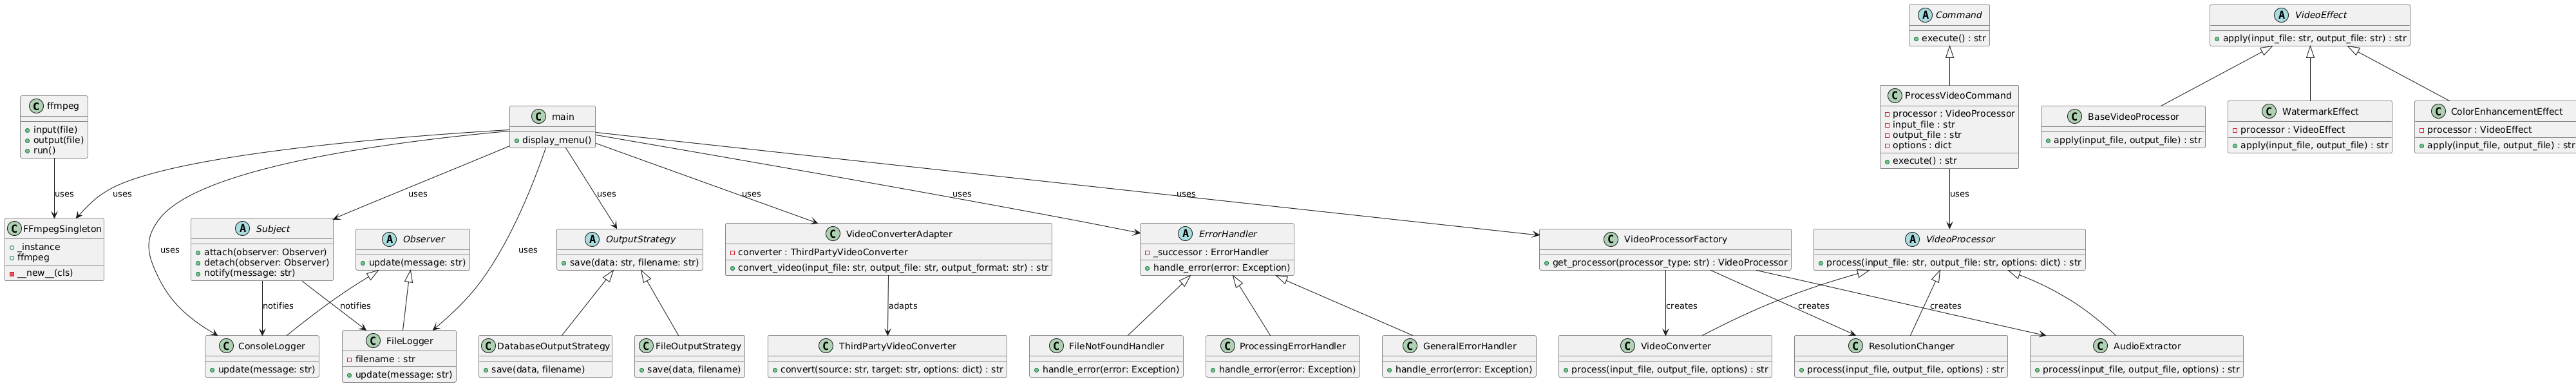

3.1 Single Pattern

The Singleton Pattern is a design pattern that ensures a class has only one instance and provides a global point of access to it. This is particularly useful when exactly one object is needed to coordinate actions across the system. In this project, the Singleton Pattern is used to manage a single instance of the FFmpeg utility.

By using the Singleton Pattern, the project ensures that there is only one instance of FFmpeg being used throughout the application, which helps in managing resources efficiently and maintaining a consistent state across the system.

In [ ]:
# Singleton Pattern
class FFmpegSingleton:
    _instance = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super(FFmpegSingleton, cls).__new__(cls)
            cls._instance.ffmpeg = ffmpeg
        return cls._instance

ffmpeg_instance = FFmpegSingleton()

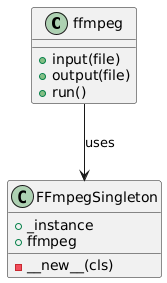

3.2 Factory Pattern

The Factory Pattern is a creational design pattern that provides an interface for creating objects in a superclass but allows subclasses to alter the type of objects that will be created. In this project, the Factory Pattern is used to create instances of different video processing tasks, encapsulating the instantiation logic and promoting flexibility and scalability.

By using the Factory Pattern, the project can easily create instances of various video processing tasks without tightly coupling the instantiation logic to the client code. This approach promotes scalability, allowing new processing tasks to be added with minimal changes to existing code.








In [ ]:
# Factory Pattern
class VideoProcessor(ABC):
    @abstractmethod
    def process(self, input_file, output_file, options):
        pass

class VideoConverter(VideoProcessor):
    def process(self, input_file, output_file, options):
        output_format = options.get('format', 'mp4')
        if not output_file.endswith(output_format):
            output_file += f'.{output_format}'
        try:
            ffmpeg_instance.ffmpeg.input(input_file).output(output_file).run(overwrite_output=True)
            return f'Conversion successful: {input_file} -> {output_file}'
        except ffmpeg_instance.ffmpeg.Error as e:
            raise ProcessingError(f'Error during conversion: {e.stderr.decode()}')

class ResolutionChanger(VideoProcessor):
    def process(self, input_file, output_file, options):
        resolution = options.get('resolution', '1280x720')
        try:
            ffmpeg_instance.ffmpeg.input(input_file).output(output_file, vf=f'scale={resolution}').run(overwrite_output=True)
            return f'Resolution change successful: {input_file} -> {output_file} with resolution {resolution}'
        except ffmpeg_instance.ffmpeg.Error as e:
            raise ProcessingError(f'Error during resolution change: {e.stderr.decode()}')

class AudioExtractor(VideoProcessor):
    def process(self, input_file, output_file, options):
        audio_format = options.get('format', 'mp3')
        if not output_file.endswith(audio_format):
            output_file += f'.{audio_format}'
        try:
            ffmpeg_instance.ffmpeg.input(input_file).output(output_file, q=0, map='a').run(overwrite_output=True)
            return f'Audio extraction successful: {input_file} -> {output_file}'
        except ffmpeg_instance.ffmpeg.Error as e:
            raise ProcessingError(f'Error during audio extraction: {e.stderr.decode()}')

class VideoProcessorFactory:
    @staticmethod
    def get_processor(processor_type):
        if processor_type == "convert":
            return VideoConverter()
        elif processor_type == "resolution":
            return ResolutionChanger()
        elif processor_type == "audio":
            return AudioExtractor()
        else:
            raise ValueError("Invalid processor type")

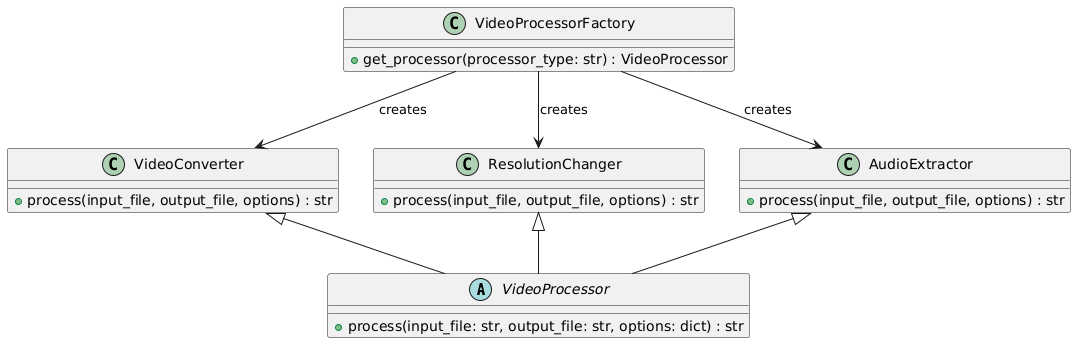

3.3 Command Pattern

The Command Pattern is a behavioral design pattern that turns a request into a stand-alone object that contains all information about the request. This transformation allows for parameterizing clients with different requests, queuing of requests, and logging the history of executed commands. In this project, the Command Pattern is used to encapsulate video processing requests as objects, making the processing tasks flexible and easier to manage.

By using the Command Pattern, the project can encapsulate video processing requests as objects, which allows for flexible execution of different processing tasks. This pattern decouples the sender and receiver of the request, providing a way to queue, log, and even undo operations if needed. This approach enhances the modularity and maintainability of the code.

In [ ]:
# Command Pattern
class Command(ABC):
    @abstractmethod
    def execute(self):
        pass

class ProcessVideoCommand(Command):
    def __init__(self, processor, input_file, output_file, options):
        self.processor = processor
        self.input_file = input_file
        self.output_file = output_file
        self.options = options

    def execute(self):
        return self.processor.process(self.input_file, self.output_file, self.options)

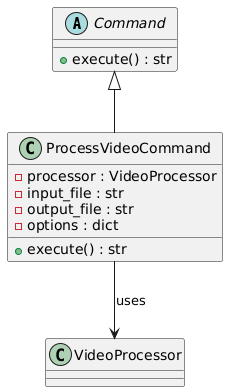

3.4 Observer Pattern

The Observer Pattern is a behavioral design pattern in which an object, known as the subject, maintains a list of its dependents, called observers, and notifies them of any state changes, usually by calling one of their methods. This pattern is useful for implementing distributed event-handling systems, where a change in one object leads to a change in one or more other objects.

By using the Observer Pattern, the project ensures that multiple objects can receive updates and respond to changes in the state of the subject. This pattern promotes loose coupling between the subject and its observers, making the system more modular and easier to maintain. Observers can be added or removed dynamically, providing flexibility in how the system handles events and notifications.

In [ ]:
# Observer Pattern
class Subject:
    def __init__(self):
        self._observers = []

    def attach(self, observer):
        self._observers.append(observer)

    def detach(self, observer):
        self._observers.remove(observer)

    def notify(self, message):
        for observer in self._observers:
            observer.update(message)

class Observer(ABC):
    @abstractmethod
    def update(self, message):
        pass

class ConsoleLogger(Observer):
    def update(self, message):
        print(f"Log: {message}")

class FileLogger(Observer):
    def __init__(self, filename):
        self.filename = filename

    def update(self, message):
        with open(self.filename, 'a') as f:
            f.write(f"Log: {message}\n")

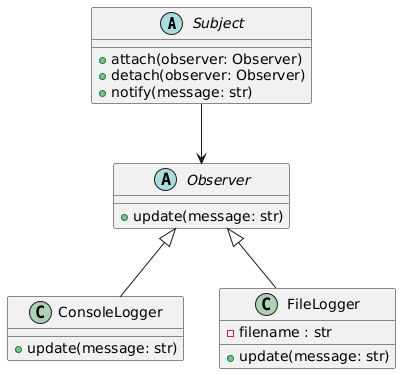

3.5 Strategy Pattern

The Strategy Pattern is a behavioral design pattern that defines a family of algorithms, encapsulates each one, and makes them interchangeable. This pattern allows the algorithm to vary independently from clients that use it. In this project, the Strategy Pattern is used to define different ways to save output data, allowing the saving mechanism to be easily switched without altering the core processing logic.

By using the Strategy Pattern, the project allows for different output strategies to be used interchangeably. This design promotes flexibility and scalability, as new saving mechanisms can be added by simply creating new subclasses of OutputStrategy without modifying existing code. It also makes the system more maintainable by separating the concerns of data processing and data saving.

In [ ]:
# Strategy Pattern
class OutputStrategy(ABC):
    @abstractmethod
    def save(self, data, filename):
        pass

class FileOutputStrategy(OutputStrategy):
    def save(self, data, filename):
        with open(filename, 'w') as f:
            f.write(data)

class DatabaseOutputStrategy(OutputStrategy):
    def save(self, data, filename):
        print(f"Saving {data} to database with key {filename}")

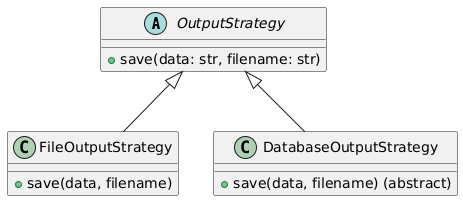

3.6 Decorator Pattern

The Decorator Pattern is a structural design pattern that allows behavior to be added to individual objects, dynamically, without affecting the behavior of other objects from the same class. It provides a flexible alternative to subclassing for extending functionality. In this project, the Decorator Pattern is used to add various video effects, such as watermarking and color enhancement, to the video processing pipeline.

By using the Decorator Pattern, the project can dynamically add additional functionalities, such as watermarking and color enhancement, to the video processing pipeline without modifying the existing code. This approach promotes flexibility and extensibility, allowing new effects to be added easily. It also supports the composition of multiple effects, as each decorator can wrap another, forming a chain of processing steps.

In [ ]:
# Decorator Pattern
class VideoEffect(ABC):
    @abstractmethod
    def apply(self, input_file, output_file):
        pass

class BaseVideoProcessor(VideoEffect):
    def apply(self, input_file, output_file):
        return f"Processed {input_file} to {output_file}"

class WatermarkEffect(VideoEffect):
    def __init__(self, processor):
        self.processor = processor

    def apply(self, input_file, output_file):
        result = self.processor.apply(input_file, output_file)
        return f"{result} with watermark"

class ColorEnhancementEffect(VideoEffect):
    def __init__(self, processor):
        self.processor = processor

    def apply(self, input_file, output_file):
        result = self.processor.apply(input_file, output_file)
        return f"{result} with enhanced colors"


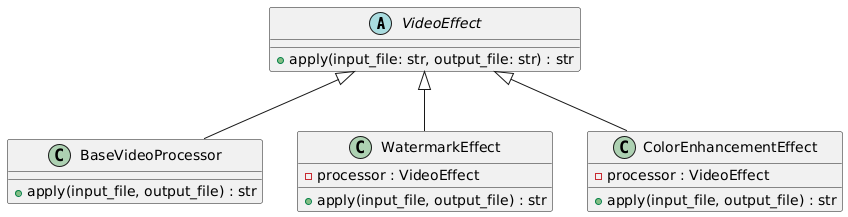

3.7 Adapter Pattern

The Adapter Pattern is a structural design pattern that allows objects with incompatible interfaces to work together. The Adapter acts as a bridge between the two incompatible interfaces. In this project, the Adapter Pattern is used to integrate a third-party video conversion service into the existing video processing system.

By using the Adapter Pattern, the project can seamlessly integrate the third-party video conversion service without modifying the existing codebase. This approach promotes reusability and flexibility, allowing the system to adapt to different interfaces and extend its functionality.

In [ ]:
# Adapter Pattern
# todo
class ThirdPartyVideoConverter:
    def convert(self, source, target, options):
        return f"Converted {source} to {target} with options {options}"

class VideoConverterAdapter:
    def __init__(self, third_party_converter):
        self.converter = third_party_converter

    def convert_video(self, input_file, output_file, output_format):
        options = {"format": output_format}
        return self.converter.convert(input_file, output_file, options)


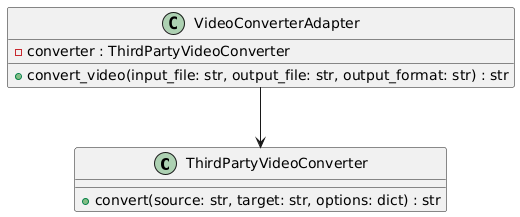

3.8 Chain of Responsibility Pattern

The Chain of Responsibility Pattern is a behavioral design pattern that passes a request along a chain of handlers. Each handler can either process the request or pass it to the next handler in the chain. This pattern decouples the sender of a request from its receiver, giving more than one object a chance to handle the request.

By using the Chain of Responsibility Pattern, the project can handle various types of errors in a flexible and extensible manner. Each error handler processes specific types of errors and delegates unhandled errors to the next handler in the chain. This approach promotes separation of concerns and makes the system more robust and maintainable.

In [ ]:
# Chain of Responsibility Pattern
class ProcessingError(Exception):
    pass

class ErrorHandler(ABC):
    def __init__(self, successor=None):
        self._successor = successor

    @abstractmethod
    def handle_error(self, error):
        pass

class FileNotFoundHandler(ErrorHandler):
    def handle_error(self, error):
        if isinstance(error, FileNotFoundError):
            print(f"File not found: {error}")
        elif self._successor:
            self._successor.handle_error(error)

class ProcessingErrorHandler(ErrorHandler):
    def handle_error(self, error):
        if isinstance(error, ProcessingError):
            print(f"Processing error occurred: {error}")
        elif self._successor:
            self._successor.handle_error(error)

class GeneralErrorHandler(ErrorHandler):
    def handle_error(self, error):
        print(f"An error occurred: {error}")

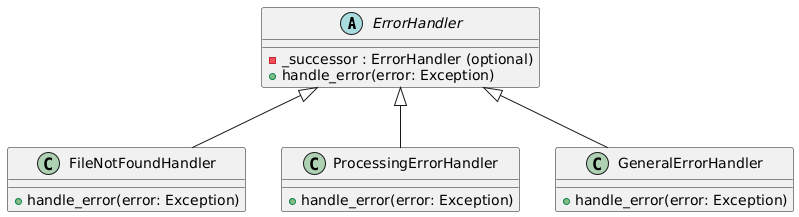

4.System Overview

The system is composed of several key components, each responsible for specific tasks related to video processing. Below is an overview of the main classes and their responsibilities:

Menu Class:

The Menu class is responsible for displaying a set of options to the user. It contains a single method display_menu(), which prints the available options for converting video formats, changing video resolutions, extracting audio, and exiting the program.
Convertor Class:

The Convertor class handles the core functionality of the application, including converting video formats, changing video resolutions, and extracting audio from video files. Each method in this class utilizes the ffmpeg library to perform these tasks. If an error occurs during processing, the error message is printed to the console.
MainProgram Class:

The MainProgram class is the entry point of the application. It contains a main() method that runs a loop, displays the menu, and processes user input. Based on the user's choice, it creates the appropriate command object and executes it to perform the requested operation.
FFmpeg Library:

The ffmpeg library is a dependency used by the Convertor class to perform media file processing tasks. It is a powerful tool for handling video, audio, and other multimedia files and streams.
Class Responsibilities
In the detailed design section, each class is elaborated with its specific responsibilities and how it contributes to the overall system functionality:

Menu Class:

display_menu(): Displays the available options to the user for video processing tasks.
Convertor Class:

convert_video_format(input_file, output_file, format): Converts a video from one format to another using FFmpeg.
change_video_resolution(input_file, output_file, resolution): Changes the resolution of a given video using FFmpeg.
extract_audio(input_file, output_file, audio_format): Extracts audio from a video file using FFmpeg.
MainProgram Class:

main(): The main loop of the application, displaying the menu and handling user input. Based on the user's choice, it creates the appropriate command object (e.g., ProcessVideoCommand) and executes it to perform the video processing task.
FFmpeg Library:

A powerful multimedia processing tool used by the Convertor class to handle video and audio files efficiently.

In [ ]:
# Main program
def display_menu():
    print("\nSelect an option:")
    print("1. Convert video format")
    print("2. Change video resolution")
    print("3. Extract audio from video")
    print("4. Apply video effects")
    print("5. Use third-party converter")
    print("6. Exit")

def main():
    video_processor_subject = Subject()
    console_logger = ConsoleLogger()
    file_logger = FileLogger("video_processing.log")
    video_processor_subject.attach(console_logger)
    video_processor_subject.attach(file_logger)

    output_strategy = FileOutputStrategy()

    # Set up error handling chain
    general_handler = GeneralErrorHandler()
    processing_handler = ProcessingErrorHandler(general_handler)
    file_handler = FileNotFoundHandler(processing_handler)

    while True:
        display_menu()
        choice = input("Enter your choice (1/2/3/4/5/6): ")

        try:
            if choice in ['1', '2', '3']:
                input_video = input("Enter input video file path: ")
                output_file = input("Enter output file path (without extension): ")

                if not os.path.exists(input_video):
                    raise FileNotFoundError(f'Input file {input_video} does not exist.')

                if choice == '1':
                    format = input("Enter desired output format (e.g., mp4, avi, mkv): ")
                    processor = VideoProcessorFactory.get_processor("convert")
                    command = ProcessVideoCommand(processor, input_video, output_file, {'format': format})
                elif choice == '2':
                    resolution = input("Enter desired resolution (e.g., 1280x720, 1920x1080): ")
                    processor = VideoProcessorFactory.get_processor("resolution")
                    command = ProcessVideoCommand(processor, input_video, output_file, {'resolution': resolution})
                else:
                    audio_format = input("Enter desired audio format (e.g., mp3, wav, aac): ")
                    processor = VideoProcessorFactory.get_processor("audio")
                    command = ProcessVideoCommand(processor, input_video, output_file, {'format': audio_format})

                result = command.execute()
                video_processor_subject.notify(result)
                output_strategy.save(result, f"{output_file}_log.txt")

            elif choice == '4':
                input_video = input("Enter input video file path: ")
                output_file = input("Enter output file path: ")

                base_processor = BaseVideoProcessor()
                watermarked_processor = WatermarkEffect(base_processor)
                enhanced_processor = ColorEnhancementEffect(watermarked_processor)

                result = enhanced_processor.apply(input_video, output_file)
                video_processor_subject.notify(result)

            elif choice == '5':
                input_video = input("Enter input video file path: ")
                output_file = input("Enter output file path: ")
                output_format = input("Enter desired output format: ")

                third_party_converter = ThirdPartyVideoConverter()
                adapter = VideoConverterAdapter(third_party_converter)
                result = adapter.convert_video(input_video, output_file, output_format)
                video_processor_subject.notify(result)

            elif choice == '6':
                print("Exiting the program.")
                break

            else:
                print("Invalid choice. Please select a valid option.")

        except Exception as e:
            file_handler.handle_error(e)

if __name__ == "__main__":
    main()


Select an option:
1. Convert video format
2. Change video resolution
3. Extract audio from video
4. Apply video effects
5. Use third-party converter
6. Exit
Enter your choice (1/2/3/4/5/6): 1


KeyboardInterrupt: Interrupted by user

5. Conclusion

This project successfully implements core video and audio processing functionalities using the ffmpeg library, with a modular design that makes the code structure clear and easy to maintain and extend. Users can conveniently perform video format conversion, resolution adjustment, and audio extraction through a simple command-line interface, greatly facilitating video processing tasks.

Achievements:
Implemented various design patterns (Singleton, Factory, Command, Adapter, Decorator, Observer, Strategy, Chain of Responsibility) to ensure modularity, scalability, and maintainability.
Provided a user-friendly command-line interface for performing complex video and audio processing tasks.
Ensured efficient performance by leveraging the powerful ffmpeg library.
Current Limitations:
The current implementation only supports single-file processing, which might be insufficient for users with batch processing needs.
Limited video editing features beyond basic format conversion, resolution adjustment, and audio extraction.

Future Enhancements:
Add batch processing capabilities to allow users to process multiple files simultaneously.
Incorporate more advanced video editing features, such as clipping, merging, and applying various filters and effects.
Develop a graphical user interface (GUI) to further enhance user experience and accessibility.
Improve error handling mechanisms to provide more detailed feedback and recovery options.
By addressing these limitations and exploring the proposed enhancements, the video and audio processing tool can become even more versatile and powerful, meeting a wider range of user needs and ensuring greater satisfaction.
